# Bridge: OME-Zarr Image - xarray.DataArray

How to best represent OME-Zarr images in xarray?

## Context

OME-Zarr images are multi-dimensional images with associated metadata. Specifically, metadata contains definitions of coordinate systems and transformations between these. xarray.DataArray coordinates can represent simple transformations such as scaling and translation. However, more complex transformations such as rotation or affine transformations cannot easily be represented in xarray coordinates. Therefore, it is not possible to represent OME-Zarr images directly as instances of xarray.DataArray.

## Some solutions

1) Use xarray coordinates for scale and transformation and perform further transformations (those that cannot be represented on an orthogonal coordinate grid) on the image data on the fly. Mask the resulting data arrays to exclude regions that are not part of the image.

2) Use multidimensional axis coordinates to represent complex transformations (experimental xarray feature).

3) Use xarray coordinates for scale and transformation and store further transformations in xarray attributes.

An example for each solution is provided in the notebook.

## Discussion

### Solution 1
Straightforward in the sense that all image and transform data is encoded in the resulting in-memory xarray objects and therefore directly compatible with all xarray methods/functionality. However, data needs to be resampled which includes an interpolation step. Also data contains invalid (masked) data points after resampling, which will need to handled. Further, transforming data on the fly can be computationally expensive.

### Solution 2
Very explicit way to represent complex transformations and coordinate arrays can require as much memory as the image data itself. This can be in part mitigated by using dask arrays as coordinate arrays. A potential downside is that the coordinate transformations rely on a relatively new xarray features that might take time before stability (see https://github.com/pydata/xarray/blob/main/design_notes/flexible_indexes_notes.md). 

### Solution 3
Makes use of xarray labels and coordinates, but outsources further transformation metadata to an unstructured attributes field. It therefore requires attaching meaning to the xarray attributes and is less explicit than solutions 1 and 2. However, no data interpolation is required and multiple coordinate systems can easily be represented. Most xarray methods would work out of the box as they wouldn't require modifying the transforms in the attributes. The solution provides significant advantages to e.g. representing an image as a numpy array + attributes as it allows for convenient implicit definitions of coordinate systems compatible with the napari model of data, physical and world coordinates.

Notably, there'd be two distinct ways to implement solution 3:
- represent scale and translation in xarray coordinates and DON'T ALLOW further transformations in the attributes to also contain scale and translation components, e.g. linear transforms would be restricted to orthonormal matrices (similar to itk images)
- same but ALLOW further transformations in the attributes to contain scale and translation components (this would be more comparable to the napari model of data, physical and world coordinates)

Existing implementations of solution 3 include
- spatial-data: extension of SpatialImage class
- xarray.DataArray - itk.Image converter

### Round trip

Which solutions support a full io round trip? (OME-Zarr Image -> xarray.DataArray -> OME-Zarr Image)

- Solution 1: no. Interpolation is performed during transformation, only one NGFF coordinate system can be represented at the time.
- Solution 2: maybe. Different coordinate systems could coexist as different xarray coordinates. Not clear how to represent the distinction between coordinate systems and transformations.
- Solution 3: yes. No data interpolation, attributes can contain all relevant metadata.



# Defining an example image

In [20]:
import dask.array as da
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from dask_image.ndinterp import affine_transform
from skimage.transform import EuclideanTransform
from spatialdata.transformations import (
    Affine,
    Identity,
    Scale,
    Sequence,
    Translation,
)
from spatialdata.transformations.transformations import _decompose_transformation

In [21]:
ndim = 2
image_np = np.random.randint(0, 255, (10,) * ndim)
# image_np = blobs()["blobs_image"].sel(c=0).data

axes = ("z", "y", "x")[-ndim:]

# build an example affine by composing multiple transformations
transformation = Sequence(
    [
        Scale([np.random.random() * 2 for dim in range(ndim)], axes=axes),
        Translation([(np.random.random() - 0.5) * 50 for dim in range(ndim)], axes=axes),
        Affine(
            EuclideanTransform(
                rotation=(np.random.random() - 0.5) * 50 / 180 * np.pi
                if ndim == 2
                else [(np.random.random() - 0.5) * 50 / 180 * np.pi for dim in range(ndim)],
                dimensionality=ndim,
            ).params,
            input_axes=axes,
            output_axes=axes,
        ),
    ]
).to_affine(input_axes=axes, output_axes=axes)

transformation

Affine (y, x -> y, x)
    [  1.21507753   0.11293748 -19.86143105]
    [-0.21618907  0.63475824 24.69626487]
    [0. 0. 1.]

## Solution 1

Use xarray coordinates for scale and transformation and perform further transformations (those that cannot be represented on an orthogonal coordinate grid) on the image data on the fly. Mask the resulting data arrays to exclude regions that are not part of the image.

Text(0.5, 1.0, 'Resampled image')

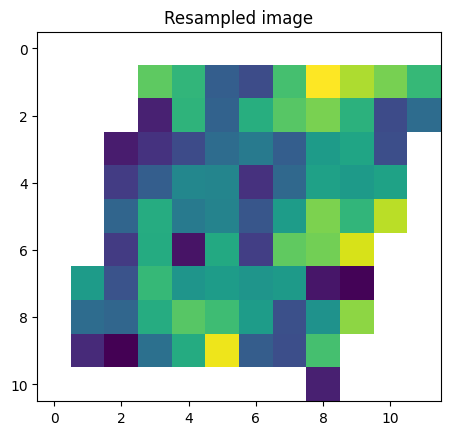

In [22]:
# decompose the transformation into its components

decomposition = _decompose_transformation(transformation=transformation, input_axes=axes, simple_decomposition=False)

# this order was taken from spatial data code
(reflection, rotation, shear, scale, translation) = decomposition.transformations

remaining_transform = Sequence([reflection, rotation, shear]).to_affine(
    input_axes=transformation.input_axes, output_axes=transformation.output_axes
)
remaining_affine = remaining_transform.to_affine_matrix(
    input_axes=transformation.input_axes, output_axes=transformation.output_axes
)

# transform the image if there is any remaining transformation
identity_affine = Identity().to_affine_matrix(
    input_axes=transformation.input_axes, output_axes=transformation.output_axes
)

if np.allclose(identity_affine, remaining_affine):
    print("return identity")

ndim = len(axes)

vertices = np.array(list(np.ndindex(tuple([2] * ndim)))) * (np.array(image_np.shape) - 1)
vertices_t = np.dot(vertices, remaining_affine[:ndim, :ndim].T) + remaining_affine[:ndim, ndim]

lower, upper = vertices_t.min(axis=0), vertices_t.max(axis=0)
output_shape = (np.ceil(upper) - np.floor(lower)).astype(np.uint16)

resampling_affine = np.linalg.inv(remaining_affine)  # need to invert here

shift = np.dot(resampling_affine[:ndim, :ndim], lower)
resampling_affine[:ndim, ndim] = shift

image_t = affine_transform(
    image_np,
    resampling_affine,
    output_shape=output_shape,
    order=1,
)

mask = (
    affine_transform(
        np.ones_like(image_np),
        resampling_affine,
        output_shape=output_shape,
        order=0,
    )
    < 1
)

image_t_masked = da.ma.masked_array(image_t, mask=mask)

image_t_xr = xr.DataArray(
    data=image_t_masked,
    dims=axes,
)

# update xarray coordinates from physical coordinates
for ax, s in zip(scale.axes, scale.scale):
    image_t_xr.coords[ax] = image_t_xr.coords[ax] * s

for ax, t in zip(translation.axes, translation.translation):
    image_t_xr.coords[ax] = image_t_xr.coords[ax] + t

# include shift
for i, (ax, l, sc) in enumerate(zip(translation.axes, lower, scale.scale)):
    image_t_xr.coords[ax] = image_t_xr.coords[ax] + l * sc

plt.figure()
plt.imshow(image_t_xr.data)
plt.title("Resampled image")

### Napari visualization

In [23]:
import napari

viewer = napari.Viewer()

viewer.add_image(
    image_np,
    affine=transformation.matrix,
    name="original",
    colormap="green",
    blending="additive",
)

viewer.add_image(
    image_t_xr.data,
    scale=np.array([image_t_xr.coords[ax].values[1] - image_t_xr.coords[ax].values[0] for ax in translation.axes]),
    translate=np.array([image_t_xr.coords[ax].values[0] for ax in translation.axes]),
    name="transformed",
    colormap="red",
    blending="additive",
    # interpolation='linear',
)

<Image layer 'transformed' at 0x344e26b50>

## Solution 2

xarray.DataArray with multidimensional axis coordinates

In [38]:
# full affine transformations
affine_matrix = transformation.to_affine_matrix(input_axes=axes, output_axes=axes)

# coordinates in pixel space
coords = da.stack([c.flatten() for c in da.meshgrid(*[np.arange(s) for s in image_np.shape])])

# transform the coordinates
coords_t = da.dot(coords.T, affine_matrix[:ndim, :ndim]) + affine_matrix[:ndim, ndim].T

# create data array
xim = xr.DataArray(
    image_np,
    dims=[str(i) for i in range(ndim)],
    coords={ax: ([str(i) for i in range(ndim)], coords_t[:, i].reshape(image_np.shape)) for i, ax in enumerate(axes)},
)

xim[1, :2].compute()  # coordinates are shown when the array is computed

<xarray.DataArray (1: 2)> Size: 16B
array([163, 204])
Coordinates:
    y        (1) float64 16B -20.08 -18.86
    x        (1) float64 16B 25.33 25.44
Dimensions without coordinates: 1

In [46]:
xim.compute()

<xarray.DataArray (0: 10, 1: 10)> Size: 800B
array([[200,  93, 209,  95, 208, 189, 252, 187, 240, 139],
       [163, 204, 116,  32,  64, 230, 224, 144,  76, 116],
       [ 34,  42, 206,  98, 249, 131, 134, 177,  81,  48],
       [ 56,  74,  35, 111,  17,  34, 147, 124, 146, 140],
       [ 65,  95, 124, 197, 122,  99, 152, 190, 139, 219],
       [173,  74, 208,  35, 132,  55, 166, 211, 254, 140],
       [252,  71, 134,  50, 192,  71, 221,  57,  29,  44],
       [178,  22, 217, 172, 160, 121, 167,  65, 150, 205],
       [ 48, 154,  38, 174, 200, 241,  67,  79, 182, 137],
       [185,  18,  41,  47,  85, 193, 199,  61,  19, 100]])
Coordinates:
    y        (0, 1) float64 800B -19.86 -18.65 -17.43 ... -13.3 -12.09 -10.87
    x        (0, 1) float64 800B 24.7 24.81 24.92 25.04 ... 31.2 31.31 31.43
Dimensions without coordinates: 0, 1

In [39]:
affine_matrix[:ndim, :ndim]

array([[ 1.21507753,  0.11293748],
       [-0.21618907,  0.63475824]])

In [36]:
coords

dask.array<stack, shape=(2, 100), dtype=int64, chunksize=(1, 100), chunktype=numpy.ndarray>

In [47]:
# this works

xim.sel({"0": slice(2)})

<xarray.DataArray (0: 2, 1: 10)> Size: 160B
array([[200,  93, 209,  95, 208, 189, 252, 187, 240, 139],
       [163, 204, 116,  32,  64, 230, 224, 144,  76, 116]])
Coordinates:
    y        (0, 1) float64 160B dask.array<chunksize=(2, 10), meta=np.ndarray>
    x        (0, 1) float64 160B dask.array<chunksize=(2, 10), meta=np.ndarray>
Dimensions without coordinates: 0, 1

In [48]:
# this doesn't work
# (need to define the index differently?)

xim.sel(y=slice(2))

KeyError: "no index found for coordinate 'y'"

## Solution 3

Use xarray coordinates for scale and transformation and store further transformations in xarray attributes.

In [49]:
image_xr = xr.DataArray(
    data=image_np,
    dims=axes,
)

# update xarray coordinates using scale and translation components
for ax, s in zip(scale.axes, scale.scale):
    image_t_xr.coords[ax] = image_t_xr.coords[ax] * s

for ax, t in zip(translation.axes, translation.translation):
    image_t_xr.coords[ax] = image_t_xr.coords[ax] + t

# include remaining transformation in attributes
image_xr.attrs["transformation"] = remaining_transform

image_xr

<xarray.DataArray (y: 10, x: 10)> Size: 800B
array([[200,  93, 209,  95, 208, 189, 252, 187, 240, 139],
       [163, 204, 116,  32,  64, 230, 224, 144,  76, 116],
       [ 34,  42, 206,  98, 249, 131, 134, 177,  81,  48],
       [ 56,  74,  35, 111,  17,  34, 147, 124, 146, 140],
       [ 65,  95, 124, 197, 122,  99, 152, 190, 139, 219],
       [173,  74, 208,  35, 132,  55, 166, 211, 254, 140],
       [252,  71, 134,  50, 192,  71, 221,  57,  29,  44],
       [178,  22, 217, 172, 160, 121, 167,  65, 150, 205],
       [ 48, 154,  38, 174, 200, 241,  67,  79, 182, 137],
       [185,  18,  41,  47,  85, 193, 199,  61,  19, 100]])
Dimensions without coordinates: y, x
Attributes:
    transformation:  Affine (y, x -> y, x)\n    [1.02399234 0.09517673 0.    ...